In [1]:
%pip install geojson
%pip install geopandas
%pip install rasterio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import geopandas as gpd
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Read the GeoJSON training file
gdf_train = gpd.read_file('data/train.geojson')
gdf_test = gpd.read_file('data/test.geojson')
# Display the first few rows of the GeoDataFrame
print(gdf_train.shape)
print(gdf_test.shape)


(20, 3)
(6, 3)


In [5]:
gdf_train.tail()

,id,label,geometry
15,15,0,"POLYGON ((21.79166 47.12736, 21.81149 47.12736..."
16,16,0,"POLYGON ((-86.26424 12.16055, -86.25044 12.160..."
17,17,0,"POLYGON ((106.94959 -6.33485, 106.96317 -6.334..."
18,18,0,"POLYGON ((-74.14197 40.53721, -74.12421 40.537..."
19,19,0,"POLYGON ((23.71918 46.79306, 23.73889 46.79306..."


In [6]:
gdf_train.iloc[0]

id                                                          0
label                                                       1
geometry    POLYGON ((-99.02345225548716 19.44625108795561...
Name: 0, dtype: object

In [28]:
%pip install pystac
%pip install pystac_client
%pip install planetary_computer

Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [130]:
def getimgdata(area_of_interest, time_of_interest):
    search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
    )

    # Check how many items were returned
    items = search.item_collection()
    print(f"Returned {len(items)} Items") if len(items)> 0 else print('No images returned')

    least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

    asset_href = least_cloudy_item.assets["visual"].href

    with rasterio.open(asset_href) as ds:
        print(f"The size of the image is {ds.height} * {ds.width} ")
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(window=aoi_window)
    
    return band_data


In [117]:
time_of_interest = "2022-01-01/2022-12-30"

In [131]:
img_data_train = [(getimgdata(row['geometry'], time_of_interest), row['label']) for _, row in gdf_train.iterrows()]


Returned 19 Items
The size of the image is 10980 * 10980 
Returned 49 Items
The size of the image is 10980 * 10980 
Returned 19 Items
The size of the image is 10980 * 10980 
Returned 1 Items
The size of the image is 10980 * 10980 
Returned 12 Items
The size of the image is 10980 * 10980 
Returned 28 Items
The size of the image is 10980 * 10980 
Returned 9 Items
The size of the image is 10980 * 10980 
Returned 4 Items
The size of the image is 10980 * 10980 
Returned 74 Items
The size of the image is 10980 * 10980 
Returned 34 Items
The size of the image is 10980 * 10980 
Returned 40 Items
The size of the image is 10980 * 10980 
Returned 49 Items
The size of the image is 10980 * 10980 
Returned 19 Items
The size of the image is 10980 * 10980 
Returned 19 Items
The size of the image is 10980 * 10980 
Returned 12 Items
The size of the image is 10980 * 10980 
Returned 28 Items
The size of the image is 10980 * 10980 
Returned 10 Items
The size of the image is 10980 * 10980 
Returned 4 Items


In [134]:
img_data_test = [(getimgdata(row['geometry'], time_of_interest), row['label']) for _, row in gdf_test.iterrows()]

Returned 38 Items
The size of the image is 10980 * 10980 
Returned 4 Items
The size of the image is 10980 * 10980 
Returned 70 Items
The size of the image is 10980 * 10980 
Returned 8 Items
The size of the image is 10980 * 10980 
Returned 1 Items
The size of the image is 10980 * 10980 
Returned 61 Items
The size of the image is 10980 * 10980 


In [135]:
img_data_train

[(array([[[151, 173, 180, ..., 255, 255, 255],
          [175, 177, 142, ..., 255, 255, 255],
          [161, 126, 120, ..., 255, 255, 255],
          ...,
          [255, 255, 255, ...,  86,  66,  69],
          [255, 255, 255, ..., 145, 111, 123],
          [255, 255, 255, ..., 184, 170, 165]],
  
         [[109, 129, 131, ..., 213, 211, 205],
          [128, 137, 111, ..., 217, 215, 209],
          [126,  98, 102, ..., 213, 222, 221],
          ...,
          [190, 193, 202, ...,  73,  57,  61],
          [203, 207, 217, ..., 124,  91,  96],
          [210, 210, 214, ..., 158, 144, 137]],
  
         [[ 88, 103, 101, ..., 165, 163, 154],
          [ 99,  97,  91, ..., 171, 169, 162],
          [ 93,  81,  88, ..., 166, 176, 175],
          ...,
          [143, 149, 152, ...,  50,  34,  37],
          [152, 158, 162, ..., 101,  79,  83],
          [155, 156, 157, ..., 134, 119, 118]]], dtype=uint8),
  1),
 (array([[[222, 221, 218, ...,  47,  46,  57],
          [222, 220, 213, ...,  

In [137]:
images_train, labels_train = zip(*img_data_train)
images_test, labels_test = zip(*img_data_test)

#### Checking for class imbalance in the training data

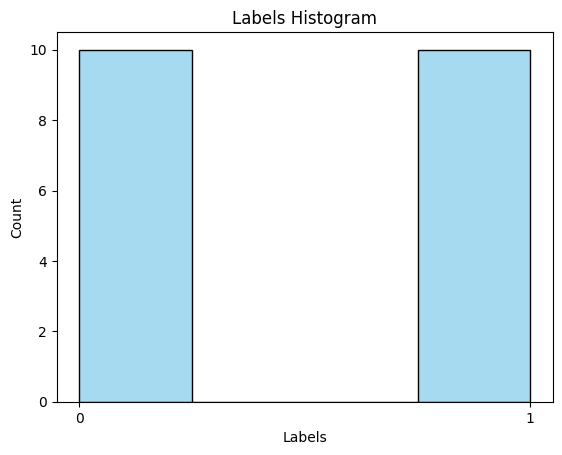

In [138]:
sns.histplot(labels_train, bins=4, kde=False, color='skyblue')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Labels Histogram')
plt.xticks([0, 1])

plt.show()

The training data does not have any class imbalance

#### Visual analysis of images

In [99]:
import random
num_list = []
for i in range(3):
    num_list.append(random.randint(0,9))
    num_list.append(random.randint(10,19))

num_list.sort()
num_list

[4, 8, 9, 14, 17, 18]

In [87]:
from IPython.display import display


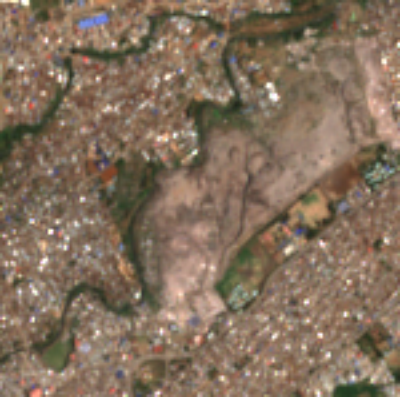

Landfilled


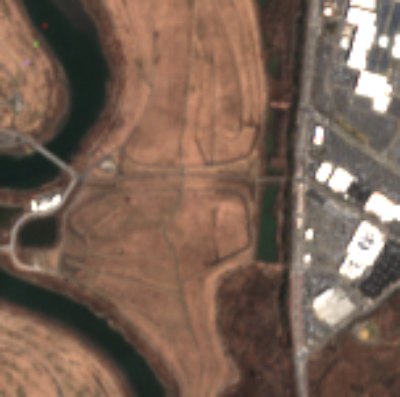

Landfilled


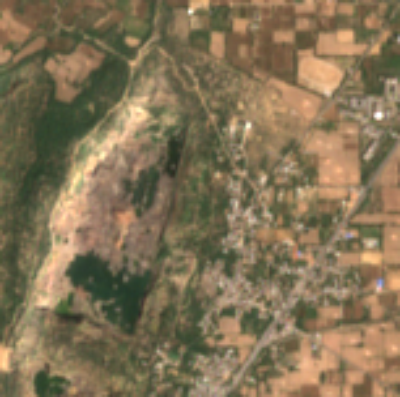

Landfilled


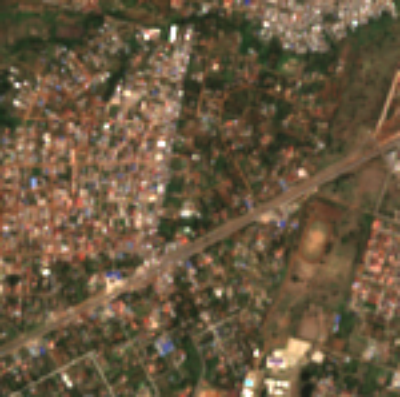

Not Landfilled


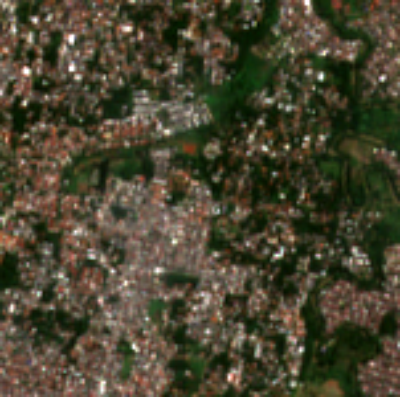

Not Landfilled


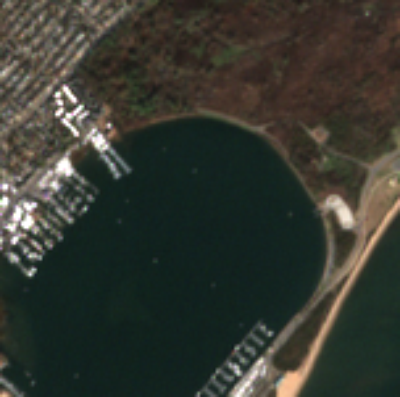

Not Landfilled


In [100]:
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 400
target_h = (int)(target_w / aspect)

for i in num_list:
    img = Image.fromarray(np.transpose(images_train[i], axes=[1, 2, 0]))
    display(img.resize((target_w, target_h), Image.Resampling.BILINEAR))
    print("Landfilled" if labels_train[i] == 1 else "Not Landfilled")

Landfilled sites have vacant spaces with sparse vegetation or development, mostly with a shade of brown indicating it, while the other sites have no distinct empty spaces with shades of brown 

### Image resolution analysis

In [ ]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=gdf_train.iloc[0]['geometry'],
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)
asset_href = least_cloudy_item.assets["visual"].href

with rasterio.open(asset_href) as ds:
    print(f"The size of the image is {ds.height} * {ds.width} ")
    aoi_bounds = features.bounds(gdf_train.iloc[0]['geometry'])
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
(np.prod(image.shape) * image.itemsize)/1024

Returned 19 Items
Choosing S2A_MSIL2A_20220401T165851_R069_T14QMG_20220402T074055 from 2022-04-01 with 1e-05% cloud cover
The size of the image is 10980 * 10980 


70.83984375

In [ ]:
response = requests.get(asset_href)
image_data = response.content

# Calculate the size of the image in megabytes
image_size_in_mb = len(image_data) / (1024 * 1024)

print(f"Image size: {image_size_in_mb:.2f} MB")

# Open the image with rasterio to access other properties if needed
with rasterio.open(BytesIO(image_data)) as src:
    width = src.width
    height = src.height
    crs = src.crs
    transform = src.transform

# Print additional image properties
print(f"Image width: {width} pixels")
print(f"Image height: {height} pixels")
print(f"CRS (Coordinate Reference System): {crs}")
print(f"Geotransform (Transform matrix): {transform}")


Image size: 340.04 MB
Image width: 10980 pixels
Image height: 10980 pixels
CRS (Coordinate Reference System): EPSG:32614
Geotransform (Transform matrix): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 2200020.00|
| 0.00, 0.00, 1.00|


In [139]:
asset_href = least_cloudy_item.assets["visual"].href
asset_href

'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/14/Q/MG/2022/04/01/S2A_MSIL2A_20220401T165851_N0400_R069_T14QMG_20220402T074055.SAFE/GRANULE/L2A_T14QMG_A035387_20220401T171542/IMG_DATA/R10m/T14QMG_20220401T165851_TCI_10m.tif?st=2023-10-15T10%3A11%3A02Z&se=2023-10-16T10%3A56%3A02Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-10-16T10%3A05%3A23Z&ske=2023-10-23T10%3A05%3A23Z&sks=b&skv=2021-06-08&sig=d4U1BpN4nLw2w7gTkB66zcyrDEzPF9zE3c3I4I3gBQE%3D'

From the URL, the string 'R10m' indicates the resolution of the images to be 10m Ground Sample Distance (GSD) and the image size is calculated to be 340.04 MB

After the Area of Interest (AOI) is taken from the original images, the size of the image of the AOI ranges from 65.478515625 to 70.83984375 KB with average size being 67.1859375 KB. 

In [142]:
image_sizes = []
for _, image in enumerate(images_train):
    image_sizes.append((np.prod(image.shape) * image.itemsize)/1024)



In [144]:
print(f"The image sizes range from {min(image_sizes)} to {max(image_sizes)} KB with average size being {np.mean(image_sizes)} KB")

The image sizes range from 65.478515625 to 70.83984375 KB with average size being 67.1859375 KB


In [105]:
max_resolution = 0
min_resolution = 200*200
max_locator = -1
min_locator = -1
for i, image in enumerate(images_train):
    resolution = image.shape[1] * image.shape[2]
    if resolution >= max_resolution:
        max_resolution = resolution
        max_locator = i
    if resolution <= min_resolution:
        min_resolution = resolution
        min_locator = i

if min_locator != -1 and max_locator != -1:
    min_image = images_train[min_locator]
    max_image = images_train[max_locator]
    print("The lowest image resolution is ", min_image.shape, "and the largest image resolution is", max_image.shape)
else:
    print("No images found in the list")

The lowest image resolution is  (3, 149, 150) and the largest image resolution is (3, 155, 156)


In [108]:
h_list = [i.shape[1] for i in images_train]
w_list = [i.shape[2] for i in images_train]
print(f"The height of pictures range from {min(h_list)} to {max(h_list)} pixels")
print(f"The width of pictures range from {min(w_list)} to {max(w_list)} pixels")


The height of pictures range from 149 to 155 pixels
The width of pictures range from 150 to 156 pixels


Given the small size of the training data and varying image sizes, downscaling the images to (3, 128, 128) will be implemented to avoid overfitting the model.